# 保存済みモデルから再学習

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow.keras as keras

from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
# base_dir = '/content/drive/My Drive/Colab Notebooks/facial-expression/input'
base_dir = '/'
print(os.listdir(base_dir))

Using TensorFlow backend.


['$Recycle.Bin', '$SysReset', 'devlist.txt', 'Documents and Settings', 'eSupport', 'Finish.log', 'hiberfil.sys', 'images', 'Intel', 'MinGW', 'OneDriveTemp', 'pagefile.sys', 'PerfLogs', 'Program Files', 'Program Files (x86)', 'ProgramData', 'Recovery', 'swapfile.sys', 'System Volume Information', 'Users', 'Windows']


In [2]:
# Pythonバージョン確認
import sys
print(sys.version)

3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]


In [3]:
# Kerasバージョン確認
print(keras.__version__)

2.2.4-tf


In [4]:
# Tensorflowバージョン確認
import tensorflow as tf
print(tf.__version__)

2.1.0


In [5]:
# Device 情報
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10547970219024818874,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3059115622
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5468454810417550243
 physical_device_desc: "device: 0, name: GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:02:00.0, compute capability: 7.5"]

In [6]:
# # googleDriveを使えるようにする（マウントする）コード
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
#data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/facial-expression/fer2013_4.csv').drop('Unnamed: 0', axis=1)

In [8]:
data = pd.read_csv('fer2013_4.csv').drop('Unnamed: 0', axis=1)

In [9]:
data.shape

(31885, 3)

In [10]:
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,0,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,0,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,0,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
data.emotion.value_counts()

0    22896
1     8989
Name: emotion, dtype: int64

In [12]:
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy()
data_test = data[data['Usage'] == 'PrivateTest'].copy()
# formatは、{}の中にformatの引数が入れられる
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (25538, 3), 
validation shape: (3174, 3), 
test shape: (3173, 3)


In [13]:
num_classes = 2  # 識別させるクラスの数
width, height = 48, 48   # 画像のサイズ
num_epochs = 100  # 「学習データをN個のサブセットに分け、それぞれ１回ずつ、学習データ全体で計N回学習させる」ということを何回繰り返し学習させるか？
batch_size = 64  # 学習データをいくつのサブセットに分けるか？例：1000の学習データを、200データの5サブセットに分ける場合、今回の学習データに対する学習は５回行われる
num_features = 64 

In [14]:
def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (25538, 48, 48, 1)
val _X shape: {},  val _Y shape: (3174, 48, 48, 1)
test _X shape: {},  test _Y shape: (3173, 48, 48, 1)


In [15]:
train_Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [16]:
train_X[1]

array([[[0.5921569 ],
        [0.5882353 ],
        [0.5764706 ],
        ...,
        [0.5058824 ],
        [0.54901963],
        [0.47058824]],

       [[0.5921569 ],
        [0.58431375],
        [0.58431375],
        ...,
        [0.47843137],
        [0.5529412 ],
        [0.5372549 ]],

       [[0.5921569 ],
        [0.5921569 ],
        [0.6117647 ],
        ...,
        [0.42745098],
        [0.48235294],
        [0.57254905]],

       ...,

       [[0.7372549 ],
        [0.7372549 ],
        [0.4745098 ],
        ...,
        [0.7254902 ],
        [0.7254902 ],
        [0.7294118 ]],

       [[0.7372549 ],
        [0.73333335],
        [0.76862746],
        ...,
        [0.7294118 ],
        [0.7137255 ],
        [0.73333335]],

       [[0.7294118 ],
        [0.72156864],
        [0.7254902 ],
        ...,
        [0.75686276],
        [0.7176471 ],
        [0.72156864]]], dtype=float32)

## モデル作成

In [17]:
# model = Sequential()

In [18]:
# ## 畳み込み層
# model.add(Conv2D(
#         2*2*num_features, 
#         kernel_size=(3,3), 
#         input_shape=(width, height, 1)
# ))
# model.add(BatchNormalization())
# ## 活性化関数
# model.add(Activation('relu'))
# ## 畳み込み層
# model.add(Conv2D(2*2*num_features, kernel_size=(3,3), padding='same'))
# model.add(BatchNormalization())
# ## 活性化関数
# model.add(Activation('relu'))
# ## プーリング層
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

In [19]:
# model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [20]:
# model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

In [21]:
# model.add(Flatten())

In [22]:
# ## dense 1
# model.add(Dense(2*2*2*num_features))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# #dense 2
# model.add(Dense(2*2*num_features))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# #dense 3
# model.add(Dense(2*num_features))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

In [23]:
# model.add(Dense(num_classes, activation='softmax'))

In [24]:
# model.compile(
#     loss='categorical_crossentropy',
#     optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
#     metrics=['accuracy']
# )
# model.summary()

In [25]:
# データ水増し
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=1,
    horizontal_flip=True
)

In [26]:
# early stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    restore_best_weights=True
)

In [27]:
# ベストモデルのみ保存する
# https://qiita.com/tom_eng_ltd/items/7ae0814c2d133431c84a
from keras.callbacks import ModelCheckpoint

modelCheckpoint = ModelCheckpoint(filepath = 'model.h5',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True, # ベストのモデルのみ保存する
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)

## ここから保存データを読み出し再学習

In [28]:
from tensorflow.keras.models import load_model

model = load_model('model_epoch100.h5') # ここは毎回書き換える
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)      

In [29]:

history = model.fit_generator(
    data_generator.flow(train_X, train_Y, batch_size),
    steps_per_epoch=len(train_X)/batch_size,
#     epochs=num_epochs,
    epochs=50, # 追加で50回学習
    verbose=1,
    callbacks=[es, modelCheckpoint], # 書き換え
    validation_data=(val_X, val_Y)
)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 399.03125 steps, validate on 3174 samples
Epoch 1/50
399/399 [============================>.] - ETA: 0s - loss: 0.3080 - accuracy: 0.8722- ETA: 9s - loss: 0.3 - ETA: 7s - los
Epoch 00001: val_loss improved from inf to 0.19258, saving model to model.h5
400/399 [==============================] - 86s 216ms/step - loss: 0.3079 - accuracy: 0.8722 - val_loss: 0.1926 - val_accuracy: 0.9279
Epoch 2/50
399/399 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.8732
Epoch 00002: val_loss did not improve from 0.19258
400/399 [==============================] - 78s 196ms/step - loss: 0.3017 - accuracy: 0.8731 - val_loss: 0.2016 - val_accuracy: 0.9269
Epoch 3/50
399/399 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.8741
Epoch 00003: val_loss did not improve from 0.19258
400/399 [==============================] - 78s 196ms/step - loss: 0.3032 - 

In [32]:
# 学習プロセスのプロット用関数

def Learning_Process_Plot(hist):
    acc = hist.history['accuracy'] # tf2.x: accuracy
    val_acc = hist.history['val_accuracy'] # tf2.x: val_accuracy
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc', ls="-", marker="o")
    plt.plot(epochs, val_acc, label='Validation acc', ls="-", marker="x")
    plt.title('Training and validation accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.figure()

    plt.plot(epochs, loss, label='Training loss', ls="-", marker="o")
    plt.plot(epochs, val_loss, label='Validation loss', ls="-", marker="x")
    plt.title('Training and validation loss')
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.show()

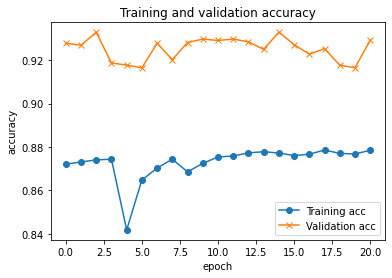

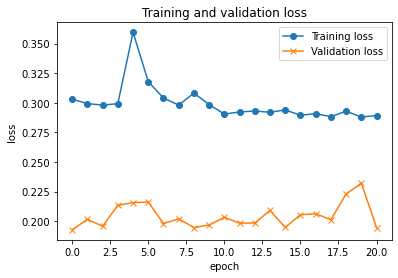

In [33]:
# 学習プロセスのプロット
Learning_Process_Plot(history)

In [34]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.9414


In [36]:
test_true

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [37]:
test_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [38]:
#model.save("drive/My Drive/Colab Notebooks/facial-expression/2020-10-24-MrIi-fer2013_4.h5")

In [39]:
# 保存したモデルをロード
from tensorflow.keras.models import load_model
# saved_model = load_model('/content/drive/My Drive/Colab Notebooks/facial-expression/2020-10-09-MrIi-fer2013_4.h5')
# saved_model2 = load_model('/content/drive/My Drive/Colab Notebooks/facial-expression/2020-10-24-MrIi-fer2013_4.h5')
saved_model = load_model('model.h5')

In [40]:
# 保存したモデルの確認としてテストデータで判別させる
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(saved_model.predict(test_X), axis=1)
print("model ver 1 CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

model ver 1 CNN Model Accuracy on test set: 0.9414


In [41]:
# # 保存したモデルの確認としてテストデータで判別させる
# test_true2 = np.argmax(test_Y, axis=1)
# test_pred2 = np.argmax(saved_model2.predict(test_X), axis=1)
# print("model ver 2CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true2, test_pred2)))

In [42]:
print(test_true)

[0 0 0 ... 0 1 0]


In [43]:
# print(test_true2)

In [44]:
u_true, counts_true = np.unique(test_true, return_counts=True)
print(u_true)

[0 1]


In [45]:
print(counts_true)

[2294  879]


In [46]:
u_pred, counts_pred = np.unique(test_pred, return_counts=True)
print(u_pred)

[0 1]


In [47]:
print(counts_pred)

[2328  845]


In [48]:
print(test_true)
test_true_bad  = np.count_nonzero(test_true == 0)
test_true_sad  = np.count_nonzero(test_true == 1)
test_true_happy  = np.count_nonzero(test_true == 2)
test_true_surprise  = np.count_nonzero(test_true == 3)
print(test_true_bad)

[0 0 0 ... 0 1 0]
2294


In [49]:
print(test_pred)
test_pred_bad  = np.count_nonzero(test_pred == 0)
test_pred_sad  = np.count_nonzero(test_pred == 1)
test_pred_happy  = np.count_nonzero(test_pred == 2)
test_pred_surprise  = np.count_nonzero(test_pred == 3)
print(test_pred_bad)

[0 0 0 ... 0 1 0]
2328


In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_true, test_pred)

Confusion Matrix
------------------
[[2218   76]
 [ 110  769]]
------------------


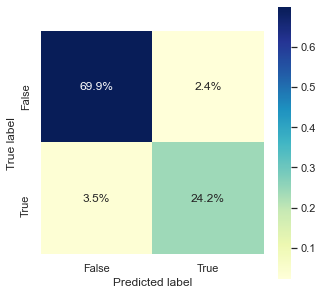

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set()

cm_rate = cm / cm.sum()

# 混合行列を描画する。
def print_confusion_matrix(confusion_matrix, class_names):
    fig = plt.figure(figsize=(5, 5))
    heatmap = sns.heatmap(
        confusion_matrix, xticklabels=class_names, yticklabels=class_names,
        annot=True, fmt='.1%', cbar=True, square=True, cmap='YlGnBu')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

labels = ["False","True"]

print("Confusion Matrix")
print("------------------")
print(cm)
print("------------------")

print_confusion_matrix(cm_rate, labels)

# 縦軸の表示がおかしいのは matplotlib 3.1.1 のバグ
# https://teratail.com/questions/205195

In [ ]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(test_true2, test_pred2)

In [52]:
# model1
target_names=["bad", "happy"]
print(classification_report(test_true, test_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

         bad     0.9527    0.9669    0.9598      2294
       happy     0.9101    0.8749    0.8921       879

    accuracy                         0.9414      3173
   macro avg     0.9314    0.9209    0.9259      3173
weighted avg     0.9409    0.9414    0.9410      3173



In [ ]:
# # model2
# target_names=["bad", "happy"]
# print(classification_report(test_true2, test_pred2, target_names=target_names))

In [53]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_true, test_pred)

In [54]:
print(fpr)

[0.        0.0331299 1.       ]


In [55]:
print(tpr)

[0.         0.87485779 1.        ]


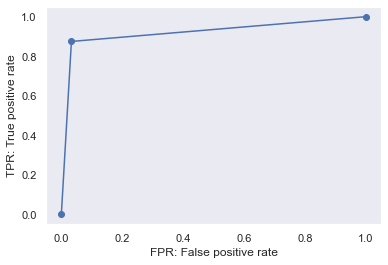

In [56]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
# plt.savefig('data/dst/sklearn_roc_curve.png')

In [57]:
from sklearn.metrics import roc_auc_score
import numpy as np

print(roc_auc_score(test_true, test_pred))

0.9208639444244421


In [ ]:
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score,f1_score
# print('confusion matrix = \n', confusion_matrix(y_true = test_true2, y_pred = test_pred2))
# print('accuracy = ',accuracy_score(y_true = test_true2 , y_pred = test_pred2))
# print('precision = ',precision_score(y_true = test_true2 , y_pred = test_pred2))
# print('recall = ',recall_score(y_true = test_true2 , y_pred = test_pred2))
# print('f1 score = ',f1_score(y_true = test_true2 , y_pred = test_pred2))
 

In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score,f1_score
print('confusion matrix = \n', confusion_matrix(y_true = test_true, y_pred = test_pred))
print('accuracy = ',accuracy_score(y_true = test_true , y_pred = test_pred))
print('precision = ',precision_score(y_true = test_true , y_pred = test_pred))
print('recall = ',recall_score(y_true = test_true , y_pred = test_pred))
print('f1 score = ',f1_score(y_true = test_true , y_pred = test_pred))
 

confusion matrix = 
 [[2218   76]
 [ 110  769]]
accuracy =  0.9413803971005358
precision =  0.9100591715976332
recall =  0.8748577929465301
f1 score =  0.8921113689095128
